##  Import libraries and load data

In [1]:
import pandas as pd
import numpy as np
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

# import warnings
# warnings.filterwarnings('ignore')

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

In [2]:
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')
full_data = [train_data, test_data]

train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Feature engineering

In [3]:
passengerId = test_data['PassengerId']

In [4]:
for dataset in full_data:
    dataset['Name_lenght'] = dataset['Name'].apply(len)
    dataset['Has_cabin'] = dataset['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    dataset['Fare'] = dataset['Fare'].fillna(train_data['Fare'].median())
    
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
    
    dataset['Title'] = dataset.Name.str.extract('([A-Za-z]+)\.', expand=False)
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 
                                                 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

C:\Users\Acer\AppData\Local\Temp\ipykernel_7608\136128640.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Acer\AppData\Local\Temp\ipykernel_7608\136128640.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [5]:
drop_features = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']

train_data = train_data.drop(drop_features, axis=1)
test_data = test_data.drop(drop_features, axis=1)

In [6]:
train_data.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_lenght,Has_cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2
3,1,1,0,2,0,3,0,44,1,2,0,3
4,0,3,1,2,0,1,0,24,0,1,1,1


## Visualisations

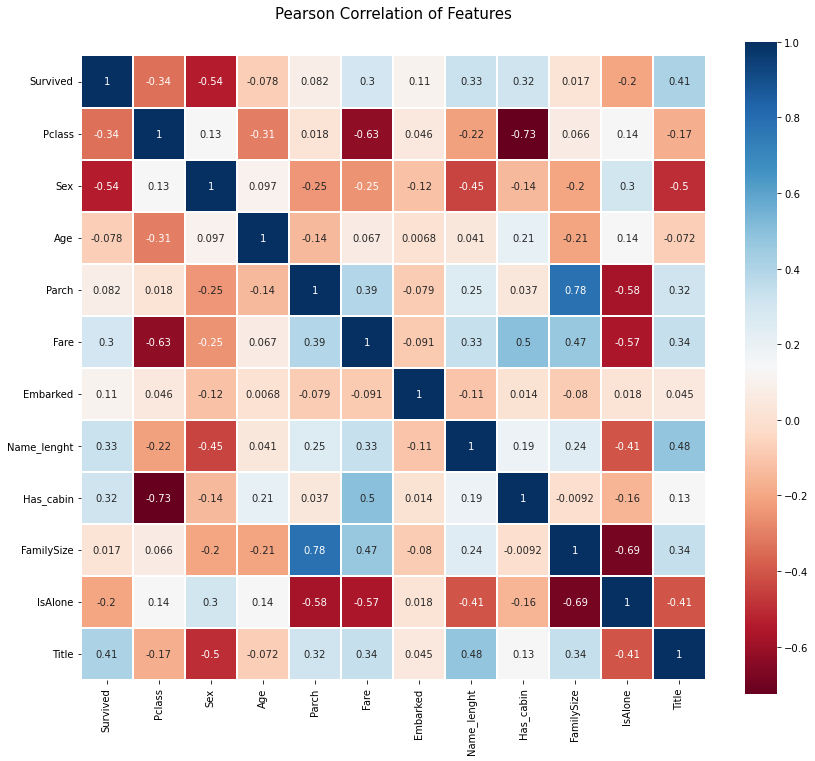

In [7]:
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_data.corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=plt.cm.RdBu, linecolor='white', annot=True);

d:\programMe\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2076: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



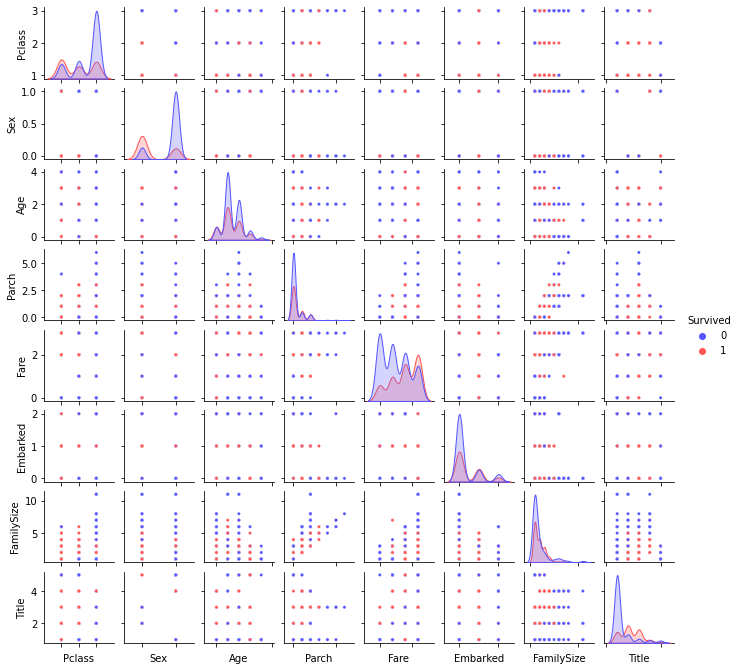

In [8]:
g = sns.pairplot(train_data[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
       u'FamilySize', u'Title']], hue='Survived', palette = 'seismic', size=1.2, diag_kind = 'kde',
                 diag_kws=dict(shade=True), plot_kws=dict(s=10))
g.set(xticklabels=[])

## Ensembling & Stacking

In [9]:
ntrain = train_data.shape[0]
ntest = test_data.shape[0]
seed = 0
nfolds = 5
kf = KFold(nfolds, shuffle=True, random_state=seed)

class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        feature_importances = self.clf.fit(x,y).feature_importances_
        print(feature_importances)
        return feature_importances

In [10]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((nfolds, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_val = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_val)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [11]:
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'warm_start': True, 
    #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

gb_params = {
    'n_estimators': 500,
    #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [12]:
rf = SklearnHelper(clf=RandomForestClassifier, seed=seed, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=seed, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=seed, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=seed, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=seed, params=svc_params)

In [13]:
y_train = train_data['Survived'].ravel()
train_data = train_data.drop(['Survived'], axis=1)
x_train = train_data.values
x_test = test_data.values

In [14]:
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

d:\programMe\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:429: UserWarning:

Warm-start fitting without increasing n_estimators does not fit new trees.

d:\programMe\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:429: UserWarning:

Warm-start fitting without increasing n_estimators does not fit new trees.

d:\programMe\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:429: UserWarning:

Warm-start fitting without increasing n_estimators does not fit new trees.

d:\programMe\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:429: UserWarning:

Warm-start fitting without increasing n_estimators does not fit new trees.



In [15]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

d:\programMe\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:429: UserWarning:

Warm-start fitting without increasing n_estimators does not fit new trees.



[0.10414325 0.20485361 0.035547   0.02030875 0.04729554 0.02807755
 0.13013858 0.04875186 0.07329847 0.01224875 0.29533663]
[0.11924392 0.38058597 0.03105335 0.01631892 0.05569109 0.02757891
 0.047409   0.08310799 0.04537327 0.02198542 0.17165218]
[0.032 0.012 0.022 0.068 0.038 0.01  0.682 0.012 0.054 0.002 0.068]
[0.08634234 0.01151463 0.06088161 0.01243282 0.05414163 0.01959305
 0.17400545 0.03636642 0.10966411 0.00698364 0.42807431]


In [16]:
cols = train_data.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_feature,
     'Extra Trees  feature importances': et_feature,
      'AdaBoost feature importances': ada_feature,
    'Gradient Boost feature importances': gb_feature
    })

In [17]:
feature_dataframe

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances
0,Pclass,0.104143,0.119244,0.032,0.086342
1,Sex,0.204854,0.380586,0.012,0.011515
2,Age,0.035547,0.031053,0.022,0.060882
3,Parch,0.020309,0.016319,0.068,0.012433
4,Fare,0.047296,0.055691,0.038,0.054142
5,Embarked,0.028078,0.027579,0.010,0.019593
6,Name_lenght,0.130139,0.047409,0.682,0.174005
7,Has_cabin,0.048752,0.083108,0.012,0.036366
8,FamilySize,0.073298,0.045373,0.054,0.109664
9,IsAlone,0.012249,0.021985,0.002,0.006984


In [18]:
feature_dataframe['mean'] = feature_dataframe.mean(axis= 1)
feature_dataframe

C:\Users\Acer\AppData\Local\Temp\ipykernel_7608\197763224.py:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.104143,0.119244,0.032,0.086342,0.085432
1,Sex,0.204854,0.380586,0.012,0.011515,0.152239
2,Age,0.035547,0.031053,0.022,0.060882,0.037370
3,Parch,0.020309,0.016319,0.068,0.012433,0.029265
4,Fare,0.047296,0.055691,0.038,0.054142,0.048782
5,Embarked,0.028078,0.027579,0.010,0.019593,0.021312
6,Name_lenght,0.130139,0.047409,0.682,0.174005,0.258388
7,Has_cabin,0.048752,0.083108,0.012,0.036366,0.045057
8,FamilySize,0.073298,0.045373,0.054,0.109664,0.070584
9,IsAlone,0.012249,0.021985,0.002,0.006984,0.010804


In [19]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x=x,
            y=y,
            width=0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize=True,
    title='Barplots of Mean Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

In [20]:
base_predictions_train = pd.DataFrame({'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


In [44]:
data = [
    go.Heatmap(
        z=base_predictions_train.astype(float).corr().values,
        x=base_predictions_train.columns.values,
        y=base_predictions_train.columns.values,
        colorscale='Viridis',
        showscale=True,
        reversescale=True,
        )
    ]
py.iplot(data, filename='labelled-heatmap')

In [45]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

In [49]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
    n_estimators= 2000,
    max_depth= 4,
    min_child_weight= 2,
    #gamma=1,
    gamma=0.9,                        
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread= -1,
    scale_pos_weight=1
    ).fit(x_train, y_train)
predictions = gbm.predict(x_test)

In [50]:
submission = pd.DataFrame({
        "PassengerId": passengerId,
        "Survived": predictions
    })
submission.to_csv('submissions/submission3.csv', index=False)